# ❄️ End-to-end ML Demo ❄️

In this worfklow we will work through the following elements of a typical tabular machine learning pipeline.

1. Use Feature Store to track engineered features

   * Store feature defintions in feature store for reproducible computation of ML features

2. Train two Models using the Snowflake ML APIs

   * Baseline XGboost
   * XGboost with optimal hyper-parameters identified via Snowflake ML distributed HPO methods

3. Register both models in Snowflake model registry

   * Explore model registry capabilities such as **metadata tracking, inference, and explainability**
   * Compare model metrics on train/test set to identify any issues of model performance or overfitting
   * Tag the best performing model version as 'default' version

4. Set up Model Monitor to track 1 year of predicted and actual loan repayments

   * **Compute performance metrics** such a F1, Precision, Recall
   * **Inspect model drift** (i.e. how much has the average predicted repayment rate changed day-to-day)
   * **Compare models** side-by-side to understand which model should be used in production
   * Identify and understand **data issues**

5. Track data and model lineage throughout

   * View and understand
     * The **origin of the data** used for computed features
     * The **data used** for model training
     * The **available model versions** being monitored

In [1]:
# Update this VERSION_NUM to version your features, models, etc.
VERSION_NUM = '0'
DB = "E2E_SNOW_MLOPS_DB"
SCHEMA = "MLOPS_SCHEMA"
COMPUTE_WAREHOUSE = "E2E_SNOW_MLOPS_WH"

[MB] NOTE: local ML development is somewhat limited.

Commented out steps must be run within Snowflake's container runtime / notebook environment.

Not yet shipped for local dev and execution in a remote container runtime:

- snowflake.ml.modeling: tune subpackage (preview feature), available within a Snowflake Notebook configured to use the Container Runtime on Snowpark Container Services (SPCS)

  [container-hpo](https://docs.snowflake.com/en/developer-guide/snowflake-ml/container-hpo)

- /snowflake.ml: feature_store subpackage (enterprise feature)

  [feature-store-details](https://docs.snowflake.com/en/developer-guide/snowflake-ml/feature-store/overview)

- ?entities

Detailed instructions on local ML development:

- [snowpark-ml-local](https://docs.snowflake.com/en/developer-guide/snowflake-ml/snowpark-ml#label-snowpark-ml-get-started)
- [snowflake-ml-function-jobs](https://docs.snowflake.com/en/developer-guide/snowflake-ml/ml-jobs/overview#label-snowflake-ml-jobs-run-function)


In [2]:
# [MB] To setup explicit connection
import os
from dotenv import load_dotenv
from snowflake.snowpark import Session

import shap
import psutil
# import math
# import pickle

from datetime import datetime
from IPython.display import display

# ML libraries
# import sklearn
import numpy as np
import pandas as pd
import streamlit as st

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml

from snowflake.ml.data import DataConnector
from snowflake.ml.registry import Registry
from snowflake.ml.monitoring import explain_visualize

# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# from snowflake.ml.modeling import tune
# from snowflake.ml.modeling.tune import get_tuner_context
# from entities import search_algorithm

# Snowflake feature store
from snowflake.ml.feature_store import (
    CreationMode, Entity, FeatureStore, FeatureView  # type: ignore
)

# Snowpark session
from snowflake import snowpark
from snowflake.snowpark import Window
from snowflake.snowpark.functions import (
    min, max,
    avg, col, sql_expr,
    to_timestamp, date_add,
    month, dayofweek, dayofyear,
)
from snowflake.snowpark.types import IntegerType, StringType
# from snowflake.snowpark import DataFrame

# Setup snowpark session
# from snowflake.snowpark.context import get_active_session

In [3]:
# [MB] Load environment variables
load_dotenv()
USER = os.getenv('SNOWSQL_USER')
ACCOUNT = os.getenv('SNOWSQL_ACCOUNT')
PASSWORD = os.getenv('SNOWSQL_PWD')

In [4]:
# [MB] Create a Snowpark session explicitly
connection_parameters = {
    "account": ACCOUNT,
    "user": USER,
    "password": PASSWORD,
    "role": "E2E_SNOW_MLOPS_ROLE",
    "warehouse": "E2E_SNOW_MLOPS_WH",
    "database": "E2E_SNOW_MLOPS_DB",
    "schema": "MLOPS_SCHEMA"
}
session = Session.builder.configs(connection_parameters).create()

# session = get_active_session()
# session

In [5]:
try:
    print("Reading table data...")
    df = session.table("MORTGAGE_LENDING_DEMO_DATA")
    display(df.to_pandas().head(5))
    # df.show(5)

    # [MB] To load explicitly from local file:
    # df_pandas = pd.read_csv("../data/MORTGAGE_LENDING_DEMO_DATA.csv.zip")
    # df = session.create_dataframe(df_pandas)

except:  # noqa: E722, B001
    print("Table not found! Uploading data to snowflake table")
    df_pandas = pd.read_csv("../data/MORTGAGE_LENDING_DEMO_DATA.csv.zip")
    session.write_pandas(
        df=df_pandas,
        table_name="MORTGAGE_LENDING_DEMO_DATA",
        auto_create_table=True
    )
    df = session.table("MORTGAGE_LENDING_DEMO_DATA")
    display(df.to_pandas().head(5))
    # df.show(5)

Reading table data...


,LOAN_ID,TS,LOAN_TYPE_NAME,LOAN_PURPOSE_NAME,APPLICANT_INCOME_000S,LOAN_AMOUNT_000S,COUNTY_NAME,MORTGAGERESPONSE
0,225846,2024-08-09 23:51:21.600,VA-guaranteed,Refinancing,NaN,160,Erie County,1
1,298793,2024-02-15 10:42:48.960,VA-guaranteed,Refinancing,109.0,255,Erie County,1
2,456295,2024-05-17 06:29:48.480,Conventional,Home purchase,283.0,392,Westchester County,1
3,376334,2024-06-21 11:55:14.880,FHA-insured,Refinancing,43.0,173,Albany County,0
4,216409,2024-10-03 17:14:38.400,Conventional,Refinancing,209.0,255,Kings County,1


## Observe Snowflake Snowpark table properties

In [6]:
df.select(min('TS'), max('TS')).show()

-----------------------------------------------------
|"MIN(""TS"")"            |"MAX(""TS"")"            |
-----------------------------------------------------
|2024-01-01 00:00:00.000  |2024-11-28 07:40:13.440  |
-----------------------------------------------------



In [7]:
# Get current date and time
current_time = datetime.now()
df_max_time = datetime.strptime(
    str(df.select(max("TS")).collect()[0][0]),
    "%Y-%m-%d %H:%M:%S.%f"
)

# Find delta between latest existing timestamp and today's date
timedelta = current_time - df_max_time

# Update timestamps to represent last ~1 year from today's date
df.select(
    min(date_add(to_timestamp("TS"), timedelta.days - 1)),
    max(date_add(to_timestamp("TS"), timedelta.days - 1))
).show()

-------------------------------------------------------------------------------------------------------
|"MIN(DATEADD('DAY', 329, TO_TIMESTAMP(""TS"")))"  |"MAX(DATEADD('DAY', 329, TO_TIMESTAMP(""TS"")))"  |
-------------------------------------------------------------------------------------------------------
|2024-11-25 00:00:00                               |2025-10-23 07:40:13.440000                        |
-------------------------------------------------------------------------------------------------------



## Feature Engineering with Snowpark APIs

In [8]:
# Create dict with keys for feature names and values containing transform code
feature_eng_dict = dict()

# Timstamp features
feature_eng_dict["TIMESTAMP"] = date_add(
    to_timestamp("TS"),
    timedelta.days - 1
)
feature_eng_dict["MONTH"] = month("TIMESTAMP")
feature_eng_dict["DAY_OF_YEAR"] = dayofyear("TIMESTAMP")
feature_eng_dict["DOTW"] = dayofweek("TIMESTAMP")

# Income and loan features
feature_eng_dict["LOAN_AMOUNT"] = col("LOAN_AMOUNT_000s") * 1000
feature_eng_dict["INCOME"] = col("APPLICANT_INCOME_000s") * 1000
feature_eng_dict["INCOME_LOAN_RATIO"] = col("INCOME") / col("LOAN_AMOUNT")

county_window_spec = Window.partition_by("COUNTY_NAME")
feature_eng_dict["MEAN_COUNTY_INCOME"] = avg("INCOME").over(county_window_spec)
feature_eng_dict["HIGH_INCOME_FLAG"] = (
    col("INCOME") > col("MEAN_COUNTY_INCOME")
).astype(IntegerType())

feature_eng_dict["AVG_THIRTY_DAY_LOAN_AMOUNT"] = sql_expr("""
AVG(LOAN_AMOUNT) OVER (
    PARTITION BY COUNTY_NAME
    ORDER BY TIMESTAMP
    RANGE BETWEEN INTERVAL '30 DAYS'
    PRECEDING AND CURRENT ROW
)""")

df = df.with_columns(
    list(feature_eng_dict.keys()),
    list(feature_eng_dict.values())
)
df.to_pandas().head(3)
# df.show(3)

,LOAN_ID,TS,LOAN_TYPE_NAME,LOAN_PURPOSE_NAME,APPLICANT_INCOME_000S,LOAN_AMOUNT_000S,COUNTY_NAME,MORTGAGERESPONSE,TIMESTAMP,MONTH,DAY_OF_YEAR,DOTW,LOAN_AMOUNT,INCOME,INCOME_LOAN_RATIO,MEAN_COUNTY_INCOME,HIGH_INCOME_FLAG,AVG_THIRTY_DAY_LOAN_AMOUNT
0,461725,2024-01-01 13:37:46.560,FHA-insured,Home purchase,NaN,63,Cattaraugus County,1,2024-11-25 13:37:46.560,11,330,1,63000,NaN,NaN,70960.056062,NaN,63000.0
1,345728,2024-01-01 16:45:41.760,Conventional,Home improvement,37.0,35,Cattaraugus County,0,2024-11-25 16:45:41.760,11,330,1,35000,37000.0,1.057143,70960.056062,0.0,49000.0
2,211511,2024-01-01 17:18:05.760,Conventional,Refinancing,71.0,64,Cattaraugus County,1,2024-11-25 17:18:05.760,11,330,1,64000,71000.0,1.109375,70960.056062,1.0,54000.0


In [9]:
df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT 
    "LOAN_ID", 
    "TS", 
    "LOAN_TYPE_NAME", 
    "LOAN_PURPOSE_NAME", 
    "APPLICANT_INCOME_000S", 
    "LOAN_AMOUNT_000S", 
    "COUNTY_NAME", 
    "MORTGAGERESPONSE", 
    dateadd('day', 329, to_timestamp("TS")) AS "TIMESTAMP", 
    month("TIMESTAMP") AS "MONTH", 
    dayofyear("TIMESTAMP") AS "DAY_OF_YEAR", 
    dayofweek("TIMESTAMP") AS "DOTW", 
    ("LOAN_AMOUNT_000S" * 1000) AS "LOAN_AMOUNT", 
    ("APPLICANT_INCOME_000S" * 1000) AS "INCOME", 
    ("INCOME" / "LOAN_AMOUNT") AS "INCOME_LOAN_RATIO", 
    avg("INCOME") OVER (PARTITION BY "COUNTY_NAME"  ) AS "MEAN_COUNTY_INCOME", 
     CAST (("INCOME" > "MEAN_COUNTY_INCOME") AS INT) AS "HIGH_INCOME_FLAG", 
    
AVG(LOAN_AMOUNT) OVER (
    PARTITION BY COUNTY_NAME
    ORDER BY TIMESTAMP
    RANGE BETWEEN INTERVAL '30 DAYS'
    PRECEDING AND CURRENT ROW
) AS "AVG_THIRTY_DAY_LOAN_AMOUNT"
 FROM MORTGAGE_LENDING_DEMO_DATA
Logical Execution Plan:
GlobalStats:
    part

## Create a Snowflake Feature Store

In [10]:
fs = FeatureStore(
    session=session,
    database=DB,
    name=SCHEMA,
    default_warehouse=COMPUTE_WAREHOUSE,
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST
)

In [11]:
fs.list_entities().to_pandas()
# fs.list_entities()

,NAME,JOIN_KEYS,DESC,OWNER
0,LOAN_ENTITY,"[""LOAN_ID""]",Features defined on a per loan level,E2E_SNOW_MLOPS_ROLE


## Feature Store configuration

- create/register entities of interest

In [12]:
# First try to retrieve an existing entity definition,
# if not define a new one and register.
try:
    # Retrieve existing entity
    loan_id_entity = fs.get_entity('LOAN_ENTITY')
    print('Retrieved existing entity')

except:  # noqa: E722, B001
    # Define new entity
    loan_id_entity = Entity(
        name="LOAN_ENTITY",
        join_keys=["LOAN_ID"],
        desc="Features defined on a per loan level"
    )
    # Register
    fs.register_entity(loan_id_entity)
    print("Registered new entity")

Retrieved existing entity


In [13]:
# Create a dataframe with just the ID, timestamp, and engineered features.
# We will use this to define our feature view.
feature_df = df.select(["LOAN_ID"] + list(feature_eng_dict.keys()))
feature_df.to_pandas().head(5)
# feature_df.show(5)

,LOAN_ID,TIMESTAMP,MONTH,DAY_OF_YEAR,DOTW,LOAN_AMOUNT,INCOME,INCOME_LOAN_RATIO,MEAN_COUNTY_INCOME,HIGH_INCOME_FLAG,AVG_THIRTY_DAY_LOAN_AMOUNT
0,461725,2024-11-25 13:37:46.560,11,330,1,63000,NaN,NaN,70960.056062,NaN,63000.0
1,345728,2024-11-25 16:45:41.760,11,330,1,35000,37000.0,1.057143,70960.056062,0.0,49000.0
2,211511,2024-11-25 17:18:05.760,11,330,1,64000,71000.0,1.109375,70960.056062,1.0,54000.0
3,207098,2024-11-25 20:36:23.040,11,330,1,6000,82000.0,13.666667,70960.056062,1.0,42000.0
4,252942,2024-11-26 05:39:24.480,11,331,2,59000,28000.0,0.474576,70960.056062,0.0,45400.0


Here, the feature store references an existing table.

We could also define the dataframe via the use of Snowpark APIs, and use that dataframe (or a function that returns a dataframe) as the feature view definition, below.

In [14]:
#define and register feature view
loan_fv = FeatureView(
    name="Mortgage_Feature_View",
    entities=[loan_id_entity],
    feature_df=feature_df,
    timestamp_col="TIMESTAMP",
    refresh_freq="1 day"
)

# Add feature level descriptions
loan_fv = loan_fv.attach_feature_desc(
    {
        "MONTH": "Month of loan",
        "DAY_OF_YEAR": "Day of calendar year of loan",
        "DOTW": "Day of the week of loan",
        "LOAN_AMOUNT": "Loan amount in $USD",
        "INCOME": "Household income in $USD",
        "INCOME_LOAN_RATIO": "Ratio of LOAN_AMOUNT/INCOME",
        "MEAN_COUNTY_INCOME": "Average household income aggregated at county level",
        "HIGH_INCOME_FLAG": "Binary flag to indicate whether household income is higher than MEAN_COUNTY_INCOME",
        "AVG_THIRTY_DAY_LOAN_AMOUNT": "Rolling 30 day average of LOAN_AMOUNT"
    }
)

loan_fv = fs.register_feature_view(
    loan_fv,
    version=VERSION_NUM,
    overwrite=True
)

/Users/matthewbain/mambaforge/envs/snowflake-playground/lib/python3.12/site-packages/snowflake/ml/feature_store/feature_store.py:2505: UserWarning: Your pipeline won't be incrementally refreshed due to: "Query contains the aggregation function on a float-typed expression as projection within comparison function, which is not supported for change tracking. Please consider replacing the floating point expression with a fixed-point number.".
  self._check_dynamic_table_refresh_mode(feature_view_name)


In [15]:
fs.list_feature_views().to_pandas()
# fs.list_feature_views()

,NAME,VERSION,DATABASE_NAME,SCHEMA_NAME,CREATED_ON,OWNER,DESC,ENTITIES,REFRESH_FREQ,REFRESH_MODE,SCHEDULING_STATE,WAREHOUSE,CLUSTER_BY,ONLINE_CONFIG
0,MORTGAGE_FEATURE_VIEW,0,E2E_SNOW_MLOPS_DB,MLOPS_SCHEMA,2025-10-24 06:40:39.363,E2E_SNOW_MLOPS_ROLE,,"[\n ""LOAN_ENTITY""\n]",1 day,FULL,ACTIVE,E2E_SNOW_MLOPS_WH,"[""LOAN_ID"", ""TIMESTAMP""]","{""enable"": false, ""target_lag"": ""10 seconds""}"


In [ ]:
# Create link to feature store UI to inspect newly created feature view!
org_name = session.sql('SELECT CURRENT_ORGANIZATION_NAME()').collect()[0][0]
account_name = session.sql('SELECT CURRENT_ACCOUNT_NAME()').collect()[0][0]

link = (
    f"https://app.snowflake.com/{org_name}/{account_name}/"
    f"#/features/database/{DB}/store/{SCHEMA}"
)
display(link)

st.write(link)
# st.write(
#     f"https://app.snowflake.com/{org_name}/{account_name}/"
#     f"#/features/database/{DB}/store/{SCHEMA}"
# )

'https://app.snowflake.com/OZMKQIL/BK71543/#/features/database/E2E_SNOW_MLOPS_DB/store/MLOPS_SCHEMA'

2025-10-24 09:42:07.878 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 09:42:07.936 
  command:

    streamlit run /Users/matthewbain/mambaforge/envs/snowflake-playground/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-10-24 09:42:07.936 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 09:42:07.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## Retrieve a Dataset from the featureview

Snowflake Datasets are immutable, file-based objects that exist within your Snowpark session. 

They can be written to persistent Snowflake objects as needed.

In [ ]:
ds = fs.generate_dataset(
    name=f"MORTGAGE_DATASET_EXTENDED_FEATURES_{VERSION_NUM}",
    spine_df=df.select(
        "LOAN_ID", "TIMESTAMP", "LOAN_PURPOSE_NAME", "MORTGAGERESPONSE"
    ),  # Only need the features used to fetch rest of feature view
    features=[loan_fv],
    spine_timestamp_col="TIMESTAMP",
    spine_label_cols=["MORTGAGERESPONSE"]
)

In [18]:
ds_sp = ds.read.to_snowpark_dataframe()
ds_sp.to_pandas().head(5)
# ds_sp.show(5)

,LOAN_ID,TIMESTAMP,LOAN_PURPOSE_NAME,MORTGAGERESPONSE,MONTH,DAY_OF_YEAR,DOTW,LOAN_AMOUNT,INCOME,INCOME_LOAN_RATIO,MEAN_COUNTY_INCOME,HIGH_INCOME_FLAG,AVG_THIRTY_DAY_LOAN_AMOUNT
0,345126,2025-01-18 10:10:24.960,Refinancing,0,1,18,6,175000,190000.0,1.085714,82967.609375,1.0,142688.984375
1,213545,2024-12-22 22:01:55.200,Home purchase,1,12,357,0,40000,38000.0,0.950000,168684.750000,0.0,335376.031250
2,283478,2025-07-13 17:19:58.080,Refinancing,1,7,194,0,720000,461000.0,0.640278,168684.750000,1.0,344139.343750
3,456300,2025-01-26 18:15:15.840,Home purchase,1,1,26,0,60000,59000.0,0.983333,100784.929688,0.0,516379.906250
4,196587,2025-07-01 03:45:12.960,Home purchase,1,7,182,2,216000,123000.0,0.569444,168684.750000,0.0,350257.718750


In [21]:
OHE_COLS = ds_sp.select(
    [col.name for col in ds_sp.schema if col.datatype == StringType()]
).columns
OHE_POST_COLS = [i + "_OHE" for i in OHE_COLS]

# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(  # type: ignore
    input_cols=OHE_COLS,
    output_cols=OHE_COLS,
    drop_input_cols=True
)
ds_sp_ohe = snowml_ohe.fit(ds_sp).transform(ds_sp)

# Rename columns to avoid double nested quotes and white space chars
rename_dict = {}
for i in ds_sp_ohe.columns:
    if '"' in i:
        rename_dict[i] = i.replace('"', '').replace(' ', '_')

ds_sp_ohe = ds_sp_ohe.rename(rename_dict)
ds_sp_ohe.columns

/Users/matthewbain/mambaforge/envs/snowflake-playground/lib/python3.12/site-packages/snowflake/ml/modeling/preprocessing/one_hot_encoder.py:519: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x[_CATEGORY], x[_COUNT])))


['LOAN_PURPOSE_NAME_HOME_IMPROVEMENT',
 'LOAN_PURPOSE_NAME_HOME_PURCHASE',
 'LOAN_PURPOSE_NAME_REFINANCING',
 'LOAN_ID',
 'TIMESTAMP',
 'MORTGAGERESPONSE',
 'MONTH',
 'DAY_OF_YEAR',
 'DOTW',
 'LOAN_AMOUNT',
 'INCOME',
 'INCOME_LOAN_RATIO',
 'MEAN_COUNTY_INCOME',
 'HIGH_INCOME_FLAG',
 'AVG_THIRTY_DAY_LOAN_AMOUNT']

In [22]:
train, test = ds_sp_ohe.random_split(weights=[0.70, 0.30], seed=0)

In [35]:
train = train.fillna(0)
test = test.fillna(0)

In [36]:
train_pd = train.to_pandas()
test_pd = test.to_pandas()

## Model Training

Below we will define and fit an xgboost classifier as our baseline model and evaluate the performance. Note this is all done with OSS frameworks.

In [37]:
# Define model config
xgb_base = XGBClassifier(
    max_depth=50,
    n_estimators=3,
    learning_rate=0.75,
    booster='gbtree'
)

In [ ]:
# Split train data into X, y
X_train_pd = train_pd.drop(
    ["TIMESTAMP", "LOAN_ID", "MORTGAGERESPONSE"],
    axis=1
)
y_train_pd = train_pd.MORTGAGERESPONSE

# Train model
xgb_base.fit(X_train_pd, y_train_pd)

,objective,'binary:logistic'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [39]:
# Update this line with correct data
train_preds_base = xgb_base.predict(X_train_pd)

f1_base_train = round(float(
    f1_score(y_train_pd, train_preds_base)
), 4)
precision_base_train = round(float(
    precision_score(y_train_pd, train_preds_base)
), 4)
recall_base_train = round(float(
    recall_score(y_train_pd, train_preds_base)
), 4)

print(
    f"F1: {f1_base_train} \n"
    f"Precision {precision_base_train} \n"
    f"Recall: {recall_base_train}"
)

F1: 0.961 
Precision 0.9347 
Recall: 0.9889


## Model Registry

- Log models with important metadata
- Manage model lifecycles
- Serve models from Snowflake runtimes

In [40]:
# Define model name
model_name = f"MORTGAGE_LENDING_MLOPS_{VERSION_NUM}"

# Create a registry to log the model to
model_registry = Registry(
    session=session,
    database_name=DB,
    schema_name=SCHEMA,
    options={"enable_monitoring": True}
)

In [ ]:
# Log the base model to the model registry (if not already there)
base_version_name = 'XGB_BASE'

try:
    # Check for existing model
    mv_base = model_registry.get_model(model_name).version(base_version_name)
    print("Found existing model version!")

except:  # noqa: E722, B001
    print("Logging new model version...")

    # Log model to registry
    mv_base = model_registry.log_model(
        model_name=model_name,
        model=xgb_base,
        version_name=base_version_name,
        sample_input_data=train.drop([
            "TIMESTAMP", "LOAN_ID", "MORTGAGERESPONSE"
        ]).limit(100),  # Using snowpark df to maintain lineage
        comment=f"""
ML model for predicting loan approval likelihood.
This model was trained using XGBoost classifier.
Hyperparameters used were:
max_depth={xgb_base.max_depth},
n_estimators={xgb_base.n_estimators},
learning_rate={xgb_base.learning_rate},
algorithm={xgb_base.booster}
""",
        target_platforms=["WAREHOUSE", "SNOWPARK_CONTAINER_SERVICES"],
        options={"enable_explainability": True}

    )

    # Set metrics
    mv_base.set_metric(metric_name="Train_F1_Score", value=f1_base_train)
    mv_base.set_metric(
        metric_name="Train_Precision_Score",
        value=precision_base_train
    )
    mv_base.set_metric(
        metric_name="Train_Recall_score",
        value=recall_base_train
    )

Found existing model version!


In [28]:
# Create tag for PROD model

# [MB] Check model_registry
# print(model_registry._database_name)
# print(model_registry._schema_name)

# [MB] Fix for: Tag 'E2E_SNOW_MLOPS_DB.MLOPS_SCHEMA.PROD' does not exist
# or not authorized.
session.sql("""
    CREATE OR REPLACE TAG E2E_SNOW_MLOPS_DB.MLOPS_SCHEMA.PROD
    COMMENT = 'Production model marker'
""")

# [MB] Check that tag successfully created
session.sql("""
    SHOW TAGS IN SCHEMA E2E_SNOW_MLOPS_DB.MLOPS_SCHEMA
""").to_pandas()

# session.sql("CREATE OR REPLACE TAG PROD")

,"""created_on""","""name""","""database_name""","""schema_name""","""owner""","""comment""","""allowed_values""","""owner_role_type""","""propagate"""
0,2025-10-17 06:14:42.697000-07:00,PROD,E2E_SNOW_MLOPS_DB,MLOPS_SCHEMA,E2E_SNOW_MLOPS_ROLE,Production model marker,None,ROLE,NONE
1,2025-10-14 06:37:02.473000-07:00,SNOWML_FEATURE_STORE_ENTITY_LOAN_ENTITY,E2E_SNOW_MLOPS_DB,MLOPS_SCHEMA,E2E_SNOW_MLOPS_ROLE,Features defined on a per loan level,"[""LOAN_ID""]",ROLE,NONE
2,2025-10-14 06:36:03.793000-07:00,SNOWML_FEATURE_STORE_OBJECT,E2E_SNOW_MLOPS_DB,MLOPS_SCHEMA,E2E_SNOW_MLOPS_ROLE,,None,ROLE,NONE
3,2025-10-14 06:36:03.638000-07:00,SNOWML_FEATURE_VIEW_METADATA,E2E_SNOW_MLOPS_DB,MLOPS_SCHEMA,E2E_SNOW_MLOPS_ROLE,,None,ROLE,NONE


In [29]:
# Apply prod tag
m = model_registry.get_model(model_name)
m.comment = "Loan approval prediction models"  # Set model level comment

m.set_tag("PROD", base_version_name)
m.show_tags()

{'E2E_SNOW_MLOPS_DB.MLOPS_SCHEMA.PROD': 'XGB_BASE'}

In [30]:
model_registry.show_models()

,created_on,name,model_type,database_name,schema_name,comment,owner,default_version_name,versions,aliases
0,2025-10-16 07:32:31.565000-07:00,MORTGAGE_LENDING_MLOPS_0,USER_MODEL,E2E_SNOW_MLOPS_DB,MLOPS_SCHEMA,Loan approval prediction models,E2E_SNOW_MLOPS_ROLE,XGB_BASE,"[""XGB_BASE""]","{""DEFAULT"":""XGB_BASE"",""FIRST"":""XGB_BASE"",""LAST..."


In [31]:
model_registry.get_model(model_name).show_versions()

,created_on,name,aliases,comment,database_name,schema_name,model_name,is_default_version,functions,metadata,user_data,model_attributes,size,environment,runnable_in,inference_services
0,2025-10-16 07:32:31.593000-07:00,XGB_BASE,"[""DEFAULT"",""FIRST"",""LAST""]",\nML model for predicting loan approval likeli...,E2E_SNOW_MLOPS_DB,MLOPS_SCHEMA,MORTGAGE_LENDING_MLOPS_0,true,"[""PREDICT_PROBA"",""EXPLAIN"",""PREDICT""]","{""metrics"": {""Train_F1_Score"": 0.9606, ""Train_...",{},"{""framework"":""xgboost"",""task"":""TABULAR_BINARY_...",3771563,"{""default"":{""python_version"":""3.12"",""cuda_vers...","[""WAREHOUSE"",""SNOWPARK_CONTAINER_SERVICES""]",[]


In [32]:
print(mv_base)
print(mv_base.show_metrics())

ModelVersion(
  name='MORTGAGE_LENDING_MLOPS_0',
  version='XGB_BASE',
)
{'Train_F1_Score': 0.9606, 'Train_Precision_Score': 0.9339, 'Train_Recall_score': 0.9889, 'Test_F1_Score': 0.9072, 'Test_Precision_Score': 0.8713, 'Test_Recall_score': 0.9462}


In [33]:
mv_base.show_functions()

[{'name': 'EXPLAIN',
  'target_method': 'explain',
  'target_method_function_type': 'TABLE_FUNCTION',
  'signature': ModelSignature(
                      inputs=[
                          FeatureSpec(dtype=DataType.INT8, name='LOAN_PURPOSE_NAME_HOME_IMPROVEMENT', nullable=True),
  		FeatureSpec(dtype=DataType.INT8, name='LOAN_PURPOSE_NAME_HOME_PURCHASE', nullable=True),
  		FeatureSpec(dtype=DataType.INT8, name='LOAN_PURPOSE_NAME_REFINANCING', nullable=True),
  		FeatureSpec(dtype=DataType.INT8, name='MONTH', nullable=True),
  		FeatureSpec(dtype=DataType.INT16, name='DAY_OF_YEAR', nullable=True),
  		FeatureSpec(dtype=DataType.INT8, name='DOTW', nullable=True),
  		FeatureSpec(dtype=DataType.INT32, name='LOAN_AMOUNT', nullable=True),
  		FeatureSpec(dtype=DataType.DOUBLE, name='INCOME', nullable=True),
  		FeatureSpec(dtype=DataType.DOUBLE, name='INCOME_LOAN_RATIO', nullable=True),
  		FeatureSpec(dtype=DataType.DOUBLE, name='MEAN_COUNTY_INCOME', nullable=True),
  		FeatureSpec(dtyp

In [34]:
reg_preds = mv_base.run(test, function_name="predict").rename(
    col('"output_feature_0"'),
    "MORTGAGE_PREDICTION"
)  # type: ignore
reg_preds.to_pandas().head(10)
# reg_preds.show(10)

,LOAN_PURPOSE_NAME_HOME_IMPROVEMENT,LOAN_PURPOSE_NAME_HOME_PURCHASE,LOAN_PURPOSE_NAME_REFINANCING,LOAN_ID,TIMESTAMP,MORTGAGERESPONSE,MONTH,DAY_OF_YEAR,DOTW,LOAN_AMOUNT,INCOME,INCOME_LOAN_RATIO,MEAN_COUNTY_INCOME,HIGH_INCOME_FLAG,AVG_THIRTY_DAY_LOAN_AMOUNT,MORTGAGE_PREDICTION
0,0,1,0,112854,2025-07-04 22:29:16.800,1,7,185,5,360000,91000.0,0.252778,168684.750000,0,346883.937500,1
1,0,1,0,286473,2024-11-23 12:48:23.040,1,11,328,6,266000,102000.0,0.383459,81078.437500,1,127629.632812,1
2,0,1,0,377610,2025-06-28 14:48:46.080,0,6,179,6,189000,42000.0,0.222222,168684.750000,0,347498.687500,1
3,0,1,0,424403,2025-07-27 04:03:04.320,1,7,208,0,340000,71000.0,0.208824,108568.820312,0,370667.875000,1
4,0,1,0,434857,2025-01-14 23:35:22.560,1,1,14,2,148000,82000.0,0.554054,82967.609375,0,142434.796875,1
5,0,1,0,321611,2025-03-13 10:42:23.040,1,3,72,4,116000,78000.0,0.672414,80911.187500,0,130457.195312,1
6,0,1,0,441268,2025-08-19 23:57:15.840,1,8,231,2,143000,0.0,0.000000,80911.187500,0,138499.531250,1
7,0,1,0,446281,2025-02-26 08:50:29.760,1,2,57,3,13000,0.0,0.000000,80911.187500,0,142183.250000,1
8,0,1,0,328070,2025-05-30 00:54:25.920,1,5,150,5,332000,110000.0,0.331325,108277.117188,1,200573.406250,1
9,0,1,0,123152,2025-08-11 21:31:58.080,1,8,223,1,412000,110000.0,0.266990,108568.820312,1,367184.875000,1


In [35]:
# ds_sp_ohe = ds_sp_ohe.rename(
#     col('"LOAN_PURPOSE_NAME_Home improvement"'),
#     "LOAN_PURPOSE_NAME_Home_improvement"
# )

preds_pd = reg_preds.select([
    "MORTGAGERESPONSE",
    "MORTGAGE_PREDICTION"
]).to_pandas()

f1_base_test = round(float(
    f1_score(preds_pd.MORTGAGERESPONSE, preds_pd.MORTGAGE_PREDICTION)
), 4)
precision_base_test = round(float(
    precision_score(preds_pd.MORTGAGERESPONSE, preds_pd.MORTGAGE_PREDICTION)
), 4)
recall_base_test = round(float(
    recall_score(preds_pd.MORTGAGERESPONSE, preds_pd.MORTGAGE_PREDICTION)
), 4)

# Log metrics to model registry model
mv_base.set_metric(metric_name="Test_F1_Score", value=f1_base_test)
mv_base.set_metric(
    metric_name="Test_Precision_Score",
    value=precision_base_test
)
mv_base.set_metric(metric_name="Test_Recall_score", value=recall_base_test)

print(
    f"F1: {f1_base_test} \nPrecision {precision_base_test} \n"
    f"Recall: {recall_base_test}"
)

F1: 0.8929 
Precision 0.855 
Recall: 0.9344


## Distributed HPO

Oh no! Our model's performance seems to have dropped off significantly from training to our test set. This is evidence that our model is overfit - can we fix this with Distributed Hyperparameter Optimization?

In [ ]:
X_train = train.drop("MORTGAGERESPONSE", "TIMESTAMP", "LOAN_ID")
y_train = train.select("MORTGAGERESPONSE")
X_test = test.drop("MORTGAGERESPONSE", "TIMESTAMP", "LOAN_ID")
y_test = test.select("MORTGAGERESPONSE")

In [ ]:
# Define dataset map
dataset_map = {
    "x_train": DataConnector.from_dataframe(X_train),
    "y_train": DataConnector.from_dataframe(y_train),
    "x_test": DataConnector.from_dataframe(X_test),
    "y_test": DataConnector.from_dataframe(y_test)
}


# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# def train_func():
#     """
#     Define a training function, with any models you choose within it.
#     """
#     # A context object provided by HPO API to expose data for the
#     # current HPO trial.
#     tuner_context = get_tuner_context()
#     config = tuner_context.get_hyper_params()
#     dm = tuner_context.get_dataset_map()

#     model = XGBClassifier(**config, random_state=42)
#     model.fit(
#         dm["x_train"].to_pandas().sort_index(),
#         dm["y_train"].to_pandas().sort_index()
#     )
#     f1_metric = f1_score(
#         dm["y_train"].to_pandas().sort_index(),
#         model.predict(dm["x_train"].to_pandas().sort_index())
#     )
#     tuner_context.report(metrics={"f1_score": f1_metric}, model=model)


# tuner = tune.Tuner(
#     train_func=train_func,
#     search_space={
#         "max_depth": tune.randint(1, 10),
#         "learning_rate": tune.uniform(0.01, 0.1),
#         "n_estimators": tune.randint(50, 100),
#     },
#     tuner_config=tune.TunerConfig(
#         metric="f1_score",
#         mode="max",
#         search_alg=search_algorithm.RandomSearch(random_state=101),
#         num_trials=8,  # Run 8 trial runs
#         # Use all available CPUs to run distributed HPO across.
#         # GPUs can also be used here!
#         max_concurrent_trials=psutil.cpu_count(logical=False)
#     ),
# )

In [38]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# Train several model candidates (note this may take 1-2 minutes)
# tuner_results = tuner.run(dataset_map=dataset_map)

In [39]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# Select best model results and inspect configuration
# tuned_model = tuner_results.best_model
# tuned_model

In [40]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# Generate predictions
# xgb_opt_preds = tuned_model.predict(train_pd.drop([
#     "TIMESTAMP", "LOAN_ID", "MORTGAGERESPONSE"
# ], axis=1))

# Generate performance metrics
# f1_opt_train = round(float(
#     f1_score(train_pd.MORTGAGERESPONSE, xgb_opt_preds)
# ), 4)
# precision_opt_train = round(float(
#     precision_score(train_pd.MORTGAGERESPONSE, xgb_opt_preds)
# ), 4)
# recall_opt_train = round(float(
#     recall_score(train_pd.MORTGAGERESPONSE, xgb_opt_preds)
# ), 4)

# print(
#     f"Train Results: \nF1: {f1_opt_train} \n"
#     f"Precision {precision_opt_train} \nRecall: {recall_opt_train}"
# )

In [41]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# Generate test predictions
# xgb_opt_preds_test = tuned_model.predict(test_pd.drop([
#     "TIMESTAMP", "LOAN_ID", "MORTGAGERESPONSE"
# ], axis=1))

# Generate performance metrics on test data
# f1_opt_test = round(float(
#     f1_score(test_pd.MORTGAGERESPONSE, xgb_opt_preds_test)
# ), 4)
# precision_opt_test = round(float(
#     precision_score(test_pd.MORTGAGERESPONSE, xgb_opt_preds_test)
# ), 4)
# recall_opt_test = round(float(
#     recall_score(test_pd.MORTGAGERESPONSE, xgb_opt_preds_test)
# ), 4)

# print(
#     f"Test Results: \nF1: {f1_opt_test} \n"
#     f"Precision {precision_opt_test} \nRecall: {recall_opt_test}"
# )

Here we see the HPO model has a more modest train accuracy than our base model - but the peformance doesn't drop off during testing.

In [42]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# Log the optimized model to the model registry (if not already there)
# optimized_version_name = 'XGB_Optimized'

# try:
#     # Check for existing model
#     mv_opt = model_registry.get_model(
#         model_name
#     ).version(optimized_version_name)

#     print("Found existing model version!")

# except:  # noqa: E722, B001
#     # Log model to registry
#     print("Logging new model version...")

#     mv_opt = model_registry.log_model(
#         model_name=model_name,
#         model=tuned_model,
#         version_name=optimized_version_name,
#         sample_input_data=train.drop([
#             "TIMESTAMP", "LOAN_ID", "MORTGAGERESPONSE"
#         ]).limit(100),
#         comment=f"""
# HPO ML model for predicting loan approval likelihood.
# This model was trained using XGBoost classifier.
# Optimized hyperparameters used were:
# max_depth={tuned_model.max_depth},
# n_estimators={tuned_model.n_estimators},
# learning_rate={tuned_model.learning_rate},
# """,
#         target_platforms=["WAREHOUSE", "SNOWPARK_CONTAINER_SERVICES"],
#         options={"enable_explainability": True}
#     )

#     # Set metrics
#     mv_opt.set_metric(
#         metric_name="Train_F1_Score",
#         value=f1_opt_train
#     )
#     mv_opt.set_metric(
#         metric_name="Train_Precision_Score",
#         value=precision_opt_train
#     )
#     mv_opt.set_metric(
#         metric_name="Train_Recall_score",
#         value=recall_opt_train
#     )

#     mv_opt.set_metric(
#         metric_name="Test_F1_Score",
#         value=f1_opt_test
#     )
#     mv_opt.set_metric(
#         metric_name="Test_Precision_Score",
#         value=precision_opt_test
#     )
#     mv_opt.set_metric(
#         metric_name="Test_Recall_score",
#         value=recall_opt_test
#     )

In [ ]:
# Here we see the BASE version is our default version
model_registry.get_model(model_name).default

ModelVersion(
  name='MORTGAGE_LENDING_MLOPS_0',
  version='XGB_BASE',
)

In [44]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# Now we'll set the optimized model to be the default model version
# going forward.
# model_registry.get_model(model_name).default = optimized_version_name

In [45]:
# Now we see our optimized version we have now recently promoted to our
# DEFAULT model version.
model_registry.get_model(model_name).default

ModelVersion(
  name='MORTGAGE_LENDING_MLOPS_0',
  version='XGB_BASE',
)

In [46]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# We'll now update the PROD tagged model to be the optimized model version
# rather than our overfit base version.
# m.unset_tag("PROD")
# m.set_tag("PROD", optimized_version_name)
# m.show_tags()

## Explainability

Now that we've deployed some model versions and tested inference, let's explain our models.

- Snowflake offers built in explainability capabilities on top of models logged to the model registry
- In the below section we'll generate shapley values using these built in functions to understand how input features impact our model's behavior

In [ ]:
# XXX
# Create a sample of 1000 records
test_pd_sample = (
    test_pd
    .rename(columns=rename_dict)
    .sample(n=2500, random_state=100)
    .reset_index(drop=True)
)

# Compute shapley values for each model
base_shap_pd = mv_base.run(test_pd_sample, function_name="explain")
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt).
# opt_shap_pd = mv_opt.run(test_pd_sample, function_name="explain")

In [49]:
feat_df = test_pd_sample.drop([
    "MORTGAGERESPONSE", "TIMESTAMP", "LOAN_ID"
], axis=1)

# [MB] NOTE: Influence sensitivity plots for a df are not supported locally
# (outside of Snowflake notebooks).
# explain_visualize.plot_influence_sensitivity(
#     base_shap_pd,
#     feat_df,
#     figsize=(1500, 500)
# )

# Optionally test out other built-in functionality
# explain_visualize.plot_force(
#     base_shap_pd.iloc[0],
#     feat_df.iloc[0],
#     figsize=(1500, 500)
# )
# explain_visualize.plot_violin(base_shap_pd, feat_df, figsize=(1400, 100))

## SHAP

In addition to built-in visualization capabilities you can always use open source packages like SHAP for additional visualizations.

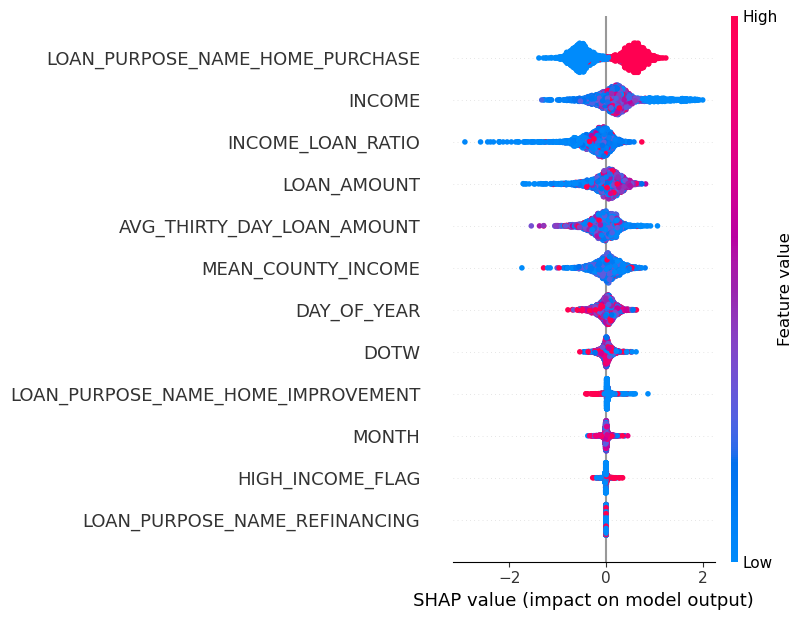

In [50]:
shap.summary_plot(
    np.array(base_shap_pd.astype(float)),  # type: ignore
    test_pd_sample.drop([
        "LOAN_ID", "MORTGAGERESPONSE", "TIMESTAMP"
    ], axis=1),
    feature_names=test_pd_sample.drop([
        "LOAN_ID", "MORTGAGERESPONSE", "TIMESTAMP"
    ], axis=1).columns
)

In [51]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd).
# shap.summary_plot(
#     np.array(opt_shap_pd.astype(float)),
#     test_pd_sample.drop([
#         "LOAN_ID", "MORTGAGERESPONSE", "TIMESTAMP"
#     ], axis=1),
#     feature_names=test_pd_sample.drop([
#         "LOAN_ID", "MORTGAGERESPONSE", "TIMESTAMP"
#     ], axis=1).columns
# )

In [52]:
# Merge shap vals and actual vals together for easier plotting below
all_shap_base = test_pd_sample.merge(
    base_shap_pd, right_index=True, left_index=True, how='outer'
)
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd).
# all_shap_opt = test_pd_sample.merge(
#     opt_shap_pd, right_index=True, left_index=True, how='outer'
# )

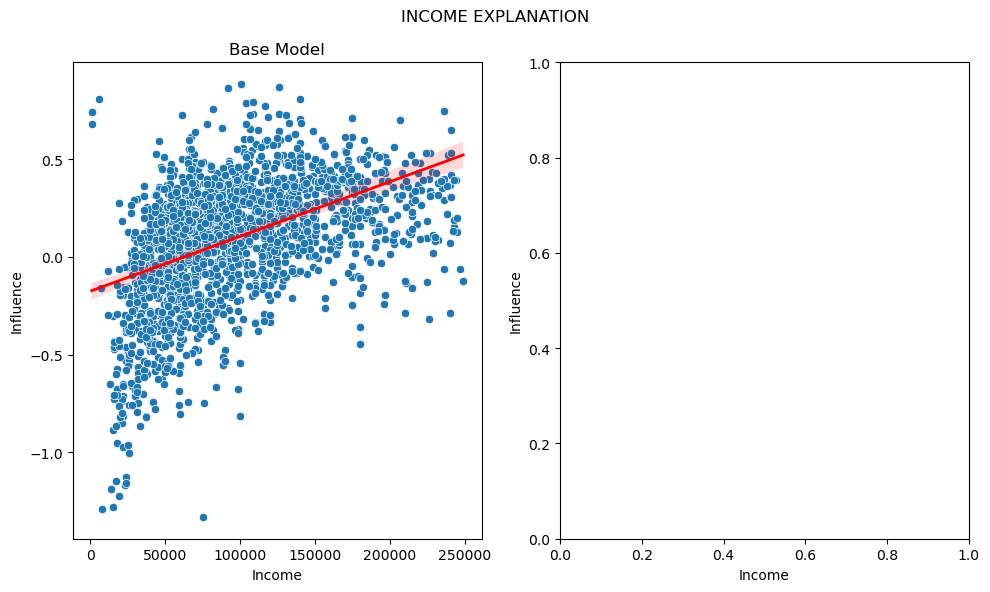

In [53]:
# Filter data down to strip outliers
asb_filtered = all_shap_base[
    (all_shap_base.INCOME > 0) &
    (all_shap_base.INCOME < 250000)
]
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd, no all_shap_opt).
# aso_filtered = all_shap_opt[
#     (all_shap_opt.INCOME > 0) &
#     (all_shap_opt.INCOME < 250000)
# ]

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("INCOME EXPLANATION")

# Plot side-by-side boxplots
sns.scatterplot(
    data=asb_filtered,
    x='INCOME',
    y='INCOME_explanation',
    ax=axes[0]
)
sns.regplot(
    data=asb_filtered,
    x="INCOME",
    y='INCOME_explanation',
    scatter=False,
    color='red',
    line_kws={"lw": 2},
    ci=100,
    lowess=False,
    ax=axes[0]
)
axes[0].set_title('Base Model')

# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd, no all_shap_opt, no aso_filterered).
# sns.scatterplot(
#     data=aso_filtered,
#     x='INCOME',
#     y='INCOME_explanation',
#     color="orange",
#     ax=axes[1]
# )
# sns.regplot(
#     data=aso_filtered,
#     x="INCOME",
#     y='INCOME_explanation',
#     scatter=False,
#     color='blue',
#     line_kws={"lw": 2},
#     ci=100,
#     lowess=False,
#     ax=axes[1]
# )
# axes[1].set_title('Opt Model')

# Customize and show the plot
for ax in axes:
    ax.set_xlabel("Income")
    ax.set_ylabel("Influence")
plt.tight_layout()
plt.show()

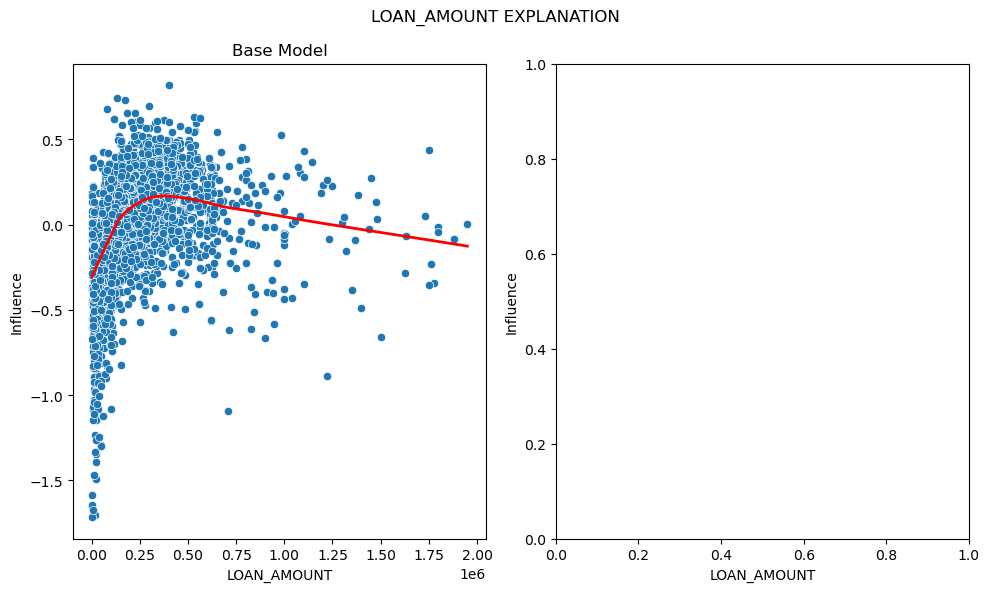

In [54]:
# Filter data down to strip outliers
asb_filtered = all_shap_base[all_shap_base.LOAN_AMOUNT < 2000000]
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd, no all_shap_opt, no aso_filterered).
# aso_filtered = all_shap_opt[all_shap_opt.LOAN_AMOUNT < 2000000]

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("LOAN_AMOUNT EXPLANATION")

# Plot side-by-side boxplots
sns.scatterplot(
    data=asb_filtered,
    x='LOAN_AMOUNT',
    y='LOAN_AMOUNT_explanation',
    ax=axes[0]
)
sns.regplot(
    data=asb_filtered,
    x="LOAN_AMOUNT",
    y='LOAN_AMOUNT_explanation',
    scatter=False,
    color='red',
    line_kws={"lw": 2},
    ci=100,
    lowess=True,
    ax=axes[0]
)
axes[0].set_title('Base Model')

# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd, no all_shap_opt, no aso_filtered).
# sns.scatterplot(
#     data=aso_filtered,
#     x='LOAN_AMOUNT',
#     y='LOAN_AMOUNT_explanation',
#     color="orange",
#     ax=axes[1]
# )
# sns.regplot(
#     data=aso_filtered,
#     x="LOAN_AMOUNT",
#     y='LOAN_AMOUNT_explanation',
#     scatter=False,
#     color='blue',
#     line_kws={"lw": 2},
#     ci=100,
#     lowess=True,
#     ax=axes[1]
# )
# axes[1].set_title('Opt Model')

# Customize and show the plot
for ax in axes:
    ax.set_xlabel("LOAN_AMOUNT")
    ax.set_ylabel("Influence")
    # ax.set_xlim((0,10000))
plt.tight_layout()
plt.show()

/var/folders/1l/bzgw9j4d1pl2c6j9ngntg5mh0000gn/T/ipykernel_71000/649352463.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


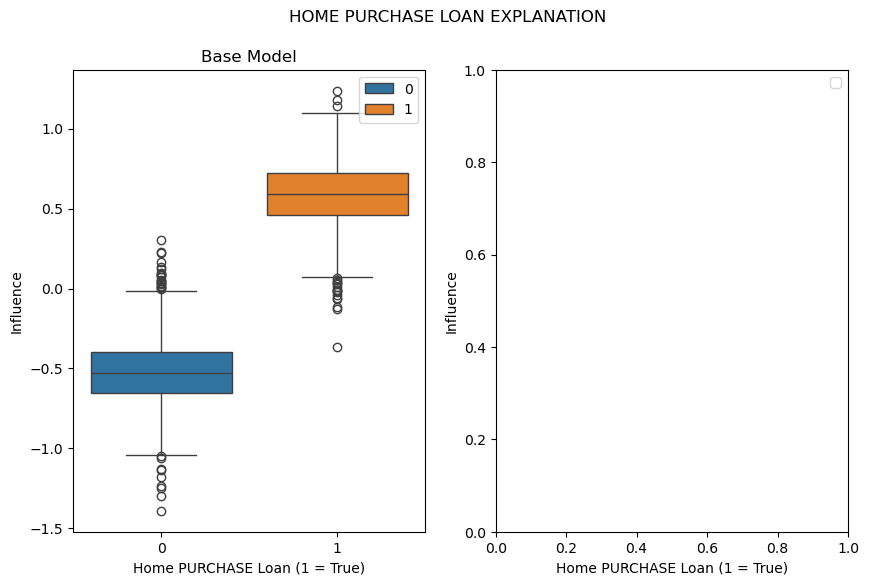

In [55]:
# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("HOME PURCHASE LOAN EXPLANATION")

# Plot side-by-side boxplots
sns.boxplot(
    data=all_shap_base,
    x='LOAN_PURPOSE_NAME_HOME_PURCHASE',
    y='LOAN_PURPOSE_NAME_HOME_PURCHASE_explanation',
    hue='LOAN_PURPOSE_NAME_HOME_PURCHASE',
    width=0.8,
    ax=axes[0]
)
axes[0].set_title('Base Model')

# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd, no all_shap_opt, no aso_filtered).
# sns.boxplot(
#     data=all_shap_opt,
#     x='LOAN_PURPOSE_NAME_HOME_PURCHASE',
#     y='LOAN_PURPOSE_NAME_HOME_PURCHASE_explanation',
#     hue='LOAN_PURPOSE_NAME_HOME_PURCHASE',
#     width=0.4,
#     ax=axes[1]
# )
# axes[1].set_title('Opt Model')

# Customize and show the plot
for ax in axes:
    ax.set_xlabel("Home PURCHASE Loan (1 = True)")
    ax.set_ylabel("Influence")
    ax.legend(loc='upper right')

plt.show()

/var/folders/1l/bzgw9j4d1pl2c6j9ngntg5mh0000gn/T/ipykernel_71000/1707548236.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


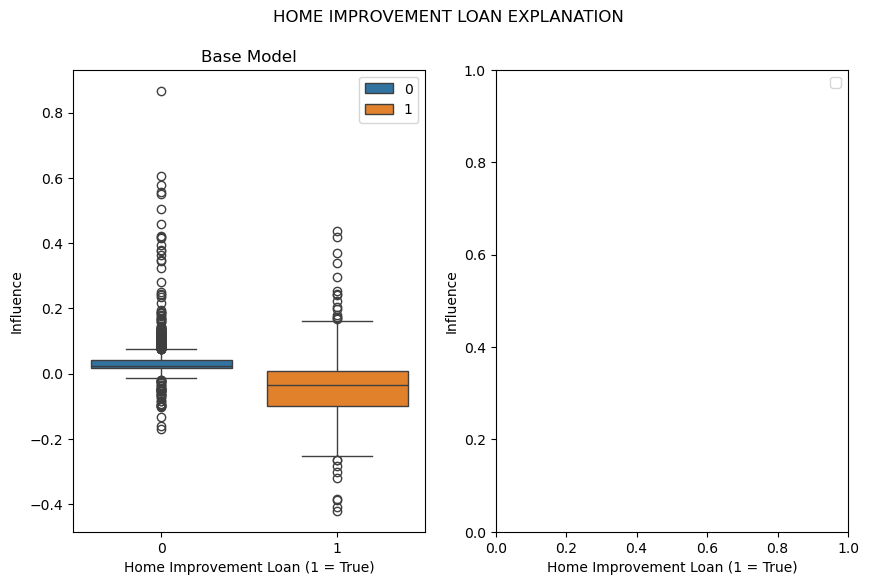

In [56]:
# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("HOME IMPROVEMENT LOAN EXPLANATION")

# Plot side-by-side boxplots
sns.boxplot(
    data=all_shap_base,
    x='LOAN_PURPOSE_NAME_HOME_IMPROVEMENT',
    y='LOAN_PURPOSE_NAME_HOME_IMPROVEMENT_explanation',
    hue='LOAN_PURPOSE_NAME_HOME_IMPROVEMENT',
    width=0.8,
    ax=axes[0]
)
axes[0].set_title('Base Model')

# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd, no all_shap_opt, no aso_filtered).
# sns.boxplot(
#     data=all_shap_opt,
#     x='LOAN_PURPOSE_NAME_HOME_IMPROVEMENT',
#     y='LOAN_PURPOSE_NAME_HOME_IMPROVEMENT_explanation',
#     hue='LOAN_PURPOSE_NAME_HOME_IMPROVEMENT',
#     width=0.4,
#     ax=axes[1]
# )
# axes[1].set_title('Opt Model')

# Customize and show the plot
for ax in axes:
    ax.set_xlabel("Home Improvement Loan (1 = True)")
    ax.set_ylabel("Influence")
    ax.legend(loc='upper right')

plt.show()

## Model Monitoring setup

In [57]:
train.write.save_as_table(
    f"DEMO_MORTGAGE_LENDING_TRAIN_{VERSION_NUM}",
    mode="overwrite"
)
test.write.save_as_table(
    f"DEMO_MORTGAGE_LENDING_TEST_{VERSION_NUM}",
    mode="overwrite"
)

In [58]:
session.sql("CREATE stage IF NOT EXISTS ML_STAGE").collect()

[Row(status='Stage area ML_STAGE successfully created.')]

In [59]:
def demo_inference_sproc(
    session: snowpark.Session,
    table_name: str,
    modelname: str,
    modelversion: str
) -> str:
    reg = Registry(session=session)
    m = reg.get_model(model_name)  # Fetch the model using the registry
    mv = m.version(modelversion)

    input_table_name = table_name
    pred_col = f'{modelversion}_PREDICTION'

    # Read the input table to a dataframe.
    # 'results' is the output DataFrame with predictions.
    df = session.table(input_table_name)
    results = (
        mv.run(df, function_name="predict")
        .select("LOAN_ID", '"output_feature_0"')  # type: ignore
        .withColumnRenamed('"output_feature_0"', pred_col)
    )

    final = df.join(results, on="LOAN_ID", how="full")

    # Write results back to Snowflake table
    final.write.save_as_table(
        table_name,
        mode='overwrite',
        enable_schema_evolution=True  # type: ignore
    )  # type: ignore

    return "Success"


# Register the stored procedure
session.sproc.register(
    func=demo_inference_sproc,
    name="model_inference_sproc",
    replace=True,
    is_permanent=True,
    stage_location="@ML_STAGE",
    packages=['joblib', 'snowflake-snowpark-python', 'snowflake-ml-python'],
    return_type=StringType()
)

In [61]:
# [MB] Reformat with Python to make use of string templating
query = f"""
CALL model_inference_sproc(
    'DEMO_MORTGAGE_LENDING_TRAIN_{VERSION_NUM}',
    '{model_name}',
    '{base_version_name}'
)
"""

df = session.sql(query)
df.show()
# CALL model_inference_sproc(
#     'DEMO_MORTGAGE_LENDING_TRAIN_{{VERSION_NUM}}',
#     '{{model_name}}',
#     '{{base_version_name}}'
# );

---------------------------
|"MODEL_INFERENCE_SPROC"  |
---------------------------
|Success                  |
---------------------------



In [62]:
# [MB] Reformat with Python to make use of string templating
query = f"""
CALL model_inference_sproc(
    'DEMO_MORTGAGE_LENDING_TEST_{VERSION_NUM}',
    '{model_name}',
    '{base_version_name}'
)
"""
df = session.sql(query)
df.show()
# CALL model_inference_sproc(
#     'DEMO_MORTGAGE_LENDING_TEST_{{VERSION_NUM}}',
#     '{{model_name}}',
#     '{{base_version_name}}'
# );

---------------------------
|"MODEL_INFERENCE_SPROC"  |
---------------------------
|Success                  |
---------------------------



In [63]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no optimized version).
# CALL model_inference_sproc(
#     'DEMO_MORTGAGE_LENDING_TRAIN_{{VERSION_NUM}}',
#     '{{model_name}}',
#     '{{optimized_version_name}}'
# );

In [64]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no optimized version).
# CALL model_inference_sproc(
#     'DEMO_MORTGAGE_LENDING_TEST_{{VERSION_NUM}}',
#     '{{model_name}}',
#     '{{optimized_version_name}}'
# );

In [90]:
# [MB] Reformat with Python to make use of string templating
query = f"""
SELECT
    TIMESTAMP,
    LOAN_ID,
    INCOME,
    LOAN_AMOUNT,
    XGB_BASE_PREDICTION,
    -- XGB_OPTIMIZED_PREDICTION,
    MORTGAGERESPONSE
FROM DEMO_MORTGAGE_LENDING_TEST_{VERSION_NUM}
LIMIT 20
"""
df = session.sql(query)
df.to_pandas()

# SELECT
#     TIMESTAMP,
#     LOAN_ID,
#     INCOME,
#     LOAN_AMOUNT,
#     XGB_BASE_PREDICTION,
#     XGB_OPTIMIZED_PREDICTION,
#     MORTGAGERESPONSE
# FROM DEMO_MORTGAGE_LENDING_TEST_{{VERSION_NUM}}
# LIMIT 20;

,TIMESTAMP,LOAN_ID,INCOME,LOAN_AMOUNT,XGB_BASE_PREDICTION,MORTGAGERESPONSE
0,2025-06-14 12:39:53.280,192406,120000.0,595000,1,1
1,2025-02-08 21:45:30.240,135832,75000.0,305000,1,1
2,2024-12-07 15:21:53.280,191178,490000.0,415000,1,1
3,2025-04-21 12:38:35.520,235193,77000.0,104000,1,1
4,2025-02-25 18:32:32.640,139858,0.0,482000,1,1
5,2025-05-23 17:47:36.960,432386,84000.0,142000,1,1
6,2025-02-12 05:53:39.840,446975,72000.0,125000,1,1
7,2025-05-08 23:24:08.640,266389,46000.0,151000,1,1
8,2024-12-31 00:56:35.520,407872,0.0,120000,1,1
9,2025-02-15 05:19:32.160,199684,64000.0,212000,1,1


## ML Observability

Now that our models have been deployed and we have run inference - lets set up ML Observability!

- First we will add a column to our inference data to later explore with our segemntation capabilities
- We will define a model monitor for each model, with the training data as our baseline and the test data representing inference results.
- Once the monitors are defined we can access them via the Model Registry
  - We can also query drift metrics etc. programmatically

In [67]:
# [MB] Reformat with Python to make use of string templating
query = f"""
ALTER TABLE DEMO_MORTGAGE_LENDING_TEST_{VERSION_NUM}
ADD COLUMN IF NOT EXISTS LOAN_PURPOSE VARCHAR(50)
"""
df = session.sql(query)
df.show()
# ALTER TABLE DEMO_MORTGAGE_LENDING_TEST_{{VERSION_NUM}}
# ADD COLUMN IF NOT EXISTS LOAN_PURPOSE VARCHAR(50);

query = f"""
UPDATE DEMO_MORTGAGE_LENDING_TEST_{VERSION_NUM}
SET LOAN_PURPOSE = CASE
    WHEN LOAN_PURPOSE_NAME_HOME_IMPROVEMENT = 1 THEN 'HOME_IMPROVEMENT'
    WHEN LOAN_PURPOSE_NAME_HOME_PURCHASE = 1 THEN 'HOME_PURCHASE'
    WHEN LOAN_PURPOSE_NAME_REFINANCING = 1 THEN 'REFINANCING'
    ELSE 'OTHER'
END
"""
df = session.sql(query)
df.show()
# UPDATE DEMO_MORTGAGE_LENDING_TEST_{{VERSION_NUM}}
# SET LOAN_PURPOSE = CASE
#     WHEN LOAN_PURPOSE_NAME_HOME_IMPROVEMENT = 1 THEN 'HOME_IMPROVEMENT'
#     WHEN LOAN_PURPOSE_NAME_HOME_PURCHASE = 1 THEN 'HOME_PURCHASE'
#     WHEN LOAN_PURPOSE_NAME_REFINANCING = 1 THEN 'REFINANCING'
#     ELSE 'OTHER'
# END;

------------------------------------
|"status"                          |
------------------------------------
|Statement executed successfully.  |
------------------------------------

--------------------------------------------------------------------
|"number of rows updated"  |"number of multi-joined rows updated"  |
--------------------------------------------------------------------
|110462                    |0                                      |
--------------------------------------------------------------------



In [68]:
# [MB] Reformat with Python to make use of string templating
query = f"""
ALTER TABLE DEMO_MORTGAGE_LENDING_TRAIN_{VERSION_NUM}
ADD COLUMN IF NOT EXISTS LOAN_PURPOSE VARCHAR(50);
"""
df = session.sql(query)
df.show()
# ALTER TABLE DEMO_MORTGAGE_LENDING_TRAIN_{{VERSION_NUM}}
# ADD COLUMN IF NOT EXISTS LOAN_PURPOSE VARCHAR(50);

query = f"""
UPDATE DEMO_MORTGAGE_LENDING_TRAIN_{VERSION_NUM}
SET LOAN_PURPOSE = CASE
    WHEN LOAN_PURPOSE_NAME_HOME_IMPROVEMENT = 1 THEN 'HOME_IMPROVEMENT'
    WHEN LOAN_PURPOSE_NAME_HOME_PURCHASE = 1 THEN 'HOME_PURCHASE'
    WHEN LOAN_PURPOSE_NAME_REFINANCING = 1 THEN 'REFINANCING'
    ELSE 'OTHER'
END
"""
df = session.sql(query)
df.show()
# UPDATE DEMO_MORTGAGE_LENDING_TRAIN_{{VERSION_NUM}}
# SET LOAN_PURPOSE = CASE
#     WHEN LOAN_PURPOSE_NAME_HOME_IMPROVEMENT = 1 THEN 'HOME_IMPROVEMENT'
#     WHEN LOAN_PURPOSE_NAME_HOME_PURCHASE = 1 THEN 'HOME_PURCHASE'
#     WHEN LOAN_PURPOSE_NAME_REFINANCING = 1 THEN 'REFINANCING'
#     ELSE 'OTHER'
# END;

------------------------------------
|"status"                          |
------------------------------------
|Statement executed successfully.  |
------------------------------------

--------------------------------------------------------------------
|"number of rows updated"  |"number of multi-joined rows updated"  |
--------------------------------------------------------------------
|258783                    |0                                      |
--------------------------------------------------------------------



In [91]:
# [MB] Reformat with Python to make use of string templating
query = f"""
SELECT
    LOAN_PURPOSE_NAME_HOME_PURCHASE,
    LOAN_PURPOSE_NAME_HOME_IMPROVEMENT,
    LOAN_PURPOSE_NAME_REFINANCING,
    LOAN_PURPOSE
FROM DEMO_MORTGAGE_LENDING_TEST_{VERSION_NUM}
LIMIT 10
"""
df = session.sql(query)
df.to_pandas()
# SELECT
#     LOAN_PURPOSE_NAME_HOME_PURCHASE,
#     LOAN_PURPOSE_NAME_HOME_IMPROVEMENT,
#     LOAN_PURPOSE_NAME_REFINANCING,
#     LOAN_PURPOSE FROM DEMO_MORTGAGE_LENDING_TEST_{{VERSION_NUM}}
# LIMIT 10;

,LOAN_PURPOSE_NAME_HOME_PURCHASE,LOAN_PURPOSE_NAME_HOME_IMPROVEMENT,LOAN_PURPOSE_NAME_REFINANCING,LOAN_PURPOSE
0,1,0,0,HOME_PURCHASE
1,1,0,0,HOME_PURCHASE
2,1,0,0,HOME_PURCHASE
3,1,0,0,HOME_PURCHASE
4,1,0,0,HOME_PURCHASE
5,1,0,0,HOME_PURCHASE
6,1,0,0,HOME_PURCHASE
7,1,0,0,HOME_PURCHASE
8,1,0,0,HOME_PURCHASE
9,1,0,0,HOME_PURCHASE


In [75]:
# [MB] Reformat with Python to make use of string templating
query = f"""
CREATE OR REPLACE MODEL MONITOR MORTGAGE_LENDING_BASE_MODEL_MONITOR
WITH
    MODEL={model_name}
    VERSION={base_version_name}
    FUNCTION=predict
    SOURCE=DEMO_MORTGAGE_LENDING_TEST_{VERSION_NUM}
    BASELINE=DEMO_MORTGAGE_LENDING_TRAIN_{VERSION_NUM}
    TIMESTAMP_COLUMN=TIMESTAMP
    PREDICTION_CLASS_COLUMNS=(XGB_BASE_PREDICTION)
    ACTUAL_CLASS_COLUMNS=(MORTGAGERESPONSE)
    ID_COLUMNS=(LOAN_ID)
    SEGMENT_COLUMNS=('LOAN_PURPOSE')
    WAREHOUSE={COMPUTE_WAREHOUSE}
    REFRESH_INTERVAL='12 hours'
    AGGREGATION_WINDOW='1 day'
"""
df = session.sql(query)
df.show()
# CREATE OR REPLACE MODEL MONITOR MORTGAGE_LENDING_BASE_MODEL_MONITOR
# WITH
#     MODEL={{model_name}}
#     VERSION={{base_version_name}}
#     FUNCTION=predict
#     SOURCE=DEMO_MORTGAGE_LENDING_TEST_{{VERSION_NUM}}
#     BASELINE=DEMO_MORTGAGE_LENDING_TRAIN_{{VERSION_NUM}}
#     TIMESTAMP_COLUMN=TIMESTAMP
#     PREDICTION_CLASS_COLUMNS=(XGB_BASE_PREDICTION)
#     ACTUAL_CLASS_COLUMNS=(MORTGAGERESPONSE)
#     ID_COLUMNS=(LOAN_ID)
#     SEGMENT_COLUMNS=('LOAN_PURPOSE')
#     WAREHOUSE={{COMPUTE_WAREHOUSE}}
#     REFRESH_INTERVAL='12 hours'
#     AGGREGATION_WINDOW='1 day';

------------------------------------------------------
|"status"                                            |
------------------------------------------------------
|Model monitor service MORTGAGE_LENDING_BASE_MOD...  |
------------------------------------------------------



In [76]:
# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no optimized version).
# CREATE OR REPLACE MODEL MONITOR MORTGAGE_LENDING_OPTIMIZED_MODEL_MONITOR
# WITH
#     MODEL={{model_name}}
#     VERSION={{optimized_version_name}}
#     FUNCTION=predict
#     SOURCE=DEMO_MORTGAGE_LENDING_TEST_{{VERSION_NUM}}
#     BASELINE=DEMO_MORTGAGE_LENDING_TRAIN_{{VERSION_NUM}}
#     TIMESTAMP_COLUMN=TIMESTAMP
#     PREDICTION_CLASS_COLUMNS=(XGB_OPTIMIZED_PREDICTION)
#     ACTUAL_CLASS_COLUMNS=(MORTGAGERESPONSE)
#     ID_COLUMNS=(LOAN_ID)
#     SEGMENT_COLUMNS=('LOAN_PURPOSE')
#     WAREHOUSE={{COMPUTE_WAREHOUSE}}
#     REFRESH_INTERVAL='12 hours'
#     AGGREGATION_WINDOW='1 day';

In [83]:
# Click the generated link to view your model in the model regsitry
# and check out the model monitors!
link = (
    f"https://app.snowflake.com/{org_name}/{account_name}"
    f"/#/data/databases/{DB}/schemas/{SCHEMA}/model/{model_name.upper()}"
)
display(link)

st.write(link)
# st.write(
#     f"https://app.snowflake.com/{org_name}/{account_name}"
#     f"/#/data/databases/{DB}/schemas/{SCHEMA}/model/{model_name.upper()}"
# )

'https://app.snowflake.com/OZMKQIL/BK71543/#/data/databases/E2E_SNOW_MLOPS_DB/schemas/MLOPS_SCHEMA/model/MORTGAGE_LENDING_MLOPS_0'

2025-10-21 10:17:44.748 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-21 10:17:44.749 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-21 10:17:44.750 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [86]:
# [MB] Reformat with Python to make use of string templating
query = """
SELECT * FROM TABLE(MODEL_MONITOR_DRIFT_METRIC(
    'MORTGAGE_LENDING_BASE_MODEL_MONITOR',  -- model monitor to use
    'DIFFERENCE_OF_MEANS',                  -- metric for computing drift
    'XGB_BASE_PREDICTION',                  -- comlumn to compute drift on
    '1 DAY',                                -- day granularity for drift calc
    DATEADD(DAY, -90, CURRENT_DATE()),      -- end date
    DATEADD(DAY, -60, CURRENT_DATE())       -- start date
))
"""
df = session.sql(query)
df.to_pandas()
# SELECT * FROM TABLE(MODEL_MONITOR_DRIFT_METRIC(
#     'MORTGAGE_LENDING_BASE_MODEL_MONITOR',  -- model monitor to use
#     'DIFFERENCE_OF_MEANS',                  -- metric for computing drift
#     'XGB_BASE_PREDICTION',                  -- comlumn to compute drift on
#     '1 DAY',                                -- day granularity for drift calc
#     DATEADD(DAY, -90, CURRENT_DATE()),      -- end date
#     DATEADD(DAY, -60, CURRENT_DATE())       -- start date
# ))

,EVENT_TIMESTAMP,METRIC_VALUE,COUNT_USED,COUNT_UNUSED,BASELINE_COUNT_USED,BASELINE_COUNT_UNUSED,METRIC_NAME,COLUMN_NAME,SEGMENT_COLUMN,SEGMENT_VALUE
0,2025-08-22,-0.024014,317.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
1,2025-08-21,-0.011994,348.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
2,2025-08-20,-0.020512,336.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
3,2025-08-19,-0.022502,338.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
4,2025-08-18,0.006670,315.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
5,2025-08-17,-0.006076,335.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
6,2025-08-16,0.005751,342.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
7,2025-08-15,0.026614,326.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
8,2025-08-14,0.017128,357.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None
9,2025-08-13,0.031377,322.0,0.0,258783,0,DIFFERENCE_OF_MEANS,XGB_BASE_PREDICTION,None,None


## SPCS Deployment setup (OPTIONAL)

This is disabled by default but uncommenting the below code cells will allow a user to:

- Create a new compute pool with 3 XL CPU nodes
- Deploy a service on top of our existing HPO model version
- Test out inference on newly created container service

In [87]:
cp_name = "MORTGAGE_LENDING_INFERENCE_CP"
num_spcs_nodes = '2'
spcs_instance_family = 'CPU_X64_L'
service_name = 'MORTGAGE_LENDING_PREDICTION_SERVICE'

current_database = (
    session.get_current_database()
    .replace('"', '')  # type: ignore
)
current_schema = (
    session.get_current_schema()
    .replace('"', '')  # type: ignore
)
extended_service_name = f'{current_database}.{current_schema}.{service_name}'

In [ ]:
session.sql(f"alter compute pool if exists {cp_name} stop all").collect()
session.sql(f"drop compute pool if exists {cp_name}").collect()
session.sql(
    f"create compute pool {cp_name} "
    f"min_nodes={num_spcs_nodes} max_nodes={num_spcs_nodes} "
    f"instance_family={spcs_instance_family} "
    "auto_resume=True auto_suspend_secs=300"
).collect()
session.sql(f"describe compute pool {cp_name}").to_pandas()
# session.sql(f"describe compute pool {cp_name}").show()

,"""name""","""state""","""min_nodes""","""max_nodes""","""instance_family""","""num_services""","""num_jobs""","""auto_suspend_secs""","""auto_resume""","""active_nodes""",...,"""target_nodes""","""created_on""","""resumed_on""","""updated_on""","""owner""","""comment""","""is_exclusive""","""application""","""error_code""","""status_message"""
0,MORTGAGE_LENDING_INFERENCE_CP,STARTING,2,2,CPU_X64_L,0,0,300,true,0,...,2,2025-10-21 07:19:24.470000-07:00,2025-10-21 07:19:24.487000-07:00,2025-10-21 07:19:24.684000-07:00,E2E_SNOW_MLOPS_ROLE,None,false,None,,Compute pool is starting for last 0 minutes


In [92]:
# NOTE: this may take up to 5 minutes to run

# [MB] NOTE: Tune subpackage not available for local use (preview feature)
# (no mv_opt, no opt_shap_pd, no all_shap_opt, no aso_filtered).
# mv_opt.create_service(
#     service_name=extended_service_name,
#     service_compute_pool=cp_name,
#     ingress_enabled=True,
#     max_instances=int(num_spcs_nodes)
# )

In [93]:
model_registry.get_model(
    f"MORTGAGE_LENDING_MLOPS_{VERSION_NUM}"
).show_versions()

,created_on,name,aliases,comment,database_name,schema_name,model_name,is_default_version,functions,metadata,user_data,model_attributes,size,environment,runnable_in,inference_services
0,2025-10-16 07:32:31.593000-07:00,XGB_BASE,"[""DEFAULT"",""FIRST"",""LAST""]",\nML model for predicting loan approval likeli...,E2E_SNOW_MLOPS_DB,MLOPS_SCHEMA,MORTGAGE_LENDING_MLOPS_0,true,"[""PREDICT_PROBA"",""EXPLAIN"",""PREDICT""]","{""metrics"": {""Train_F1_Score"": 0.9606, ""Train_...",{},"{""framework"":""xgboost"",""task"":""TABULAR_BINARY_...",3771563,"{""default"":{""python_version"":""3.12"",""cuda_vers...","[""WAREHOUSE"",""SNOWPARK_CONTAINER_SERVICES""]",[]


In [ ]:
mv_container = model_registry.get_model(
    f"MORTGAGE_LENDING_MLOPS_{VERSION_NUM}"
).default

# BUG: SQL compilation error: Unknown user-defined function
# E2E_SNOW_MLOPS_DB.MLOPS_SCHEMA.MORTGAGE_LENDING_PREDICTION_SERVICE!PREDICT.
# mv_container.run(
#     test,
#     function_name="predict",
#     service_name="MORTGAGE_LENDING_PREDICTION_SERVICE"
# ).rename('"output_feature_0"', 'XGB_PREDICTION')  # type: ignore

In [101]:
# BUG: SQL compilation error: Service does not exist or not authorized:
# 'E2E_SNOW_MLOPS_DB.MLOPS_SCHEMA.MORTGAGE_LENDING_PREDICTION_SERVICE'.
# query = """
# SHOW ENDPOINTS
# IN SERVICE E2E_SNOW_MLOPS_DB.MLOPS_SCHEMA.MORTGAGE_LENDING_PREDICTION_SERVICE
# """
# session.sql(query).to_pandas()

In [ ]:
# Stop the service to save costs
# session.sql(f"alter compute pool if exists {cp_name} stop all").collect()

## Conclusion

- 🛠️ Snowflake Feature Store tracks feature definitions and maintains lineage of sources and destinations

- 🚀 Snowflake Model Registry gives users a secure and flexible framework to log models, tag candidates for production, and run inference and explainability jobs

- 📈 ML observability in Snowflake allows users to montior model performance over time and detect model, feature, and concept drift

- 🔮 All models logged in the Model Registry can be accessed for inference, explainability, lineage tracking, visibility and more